In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.master("local").appName("Irish Marine Institute - Data Prep").getOrCreate()

In [3]:
df = spark.read.csv("dataset/IrishNationalTideGaugeNetwork.csv", header=True, inferSchema=True)
df.show(vertical=True)

-RECORD 0------------------------------------
 time                 | UTC                  
 altitude             | m                    
 latitude             | degrees_north        
 longitude            | degrees_east         
 station_id           | null                 
 datasourceid         | null                 
 Water_Level_LAT      | metres               
 Water_Level_OD_Malin | metres               
 QC_Flag              | null                 
-RECORD 1------------------------------------
 time                 | 2006-10-26T13:00:00Z 
 altitude             | 0.0                  
 latitude             | 53.585               
 longitude            | -6.1081              
 station_id           | Skerries Harbour     
 datasourceid         | 11                   
 Water_Level_LAT      | 4.679                
 Water_Level_OD_Malin | 1.82                 
 QC_Flag              | 1                    
-RECORD 2------------------------------------
 time                 | 2006-10-26

In [4]:
df.printSchema()

root
 |-- time: string (nullable = true)
 |-- altitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- station_id: string (nullable = true)
 |-- datasourceid: integer (nullable = true)
 |-- Water_Level_LAT: string (nullable = true)
 |-- Water_Level_OD_Malin: string (nullable = true)
 |-- QC_Flag: integer (nullable = true)



In [5]:
from pyspark.sql.functions import from_utc_timestamp
from pyspark.sql.functions import col
from pyspark.sql.functions import year, to_date
from pyspark.sql.functions import dayofmonth, month, year,hour, minute

df = df.filter((df.latitude == '53.585') & (df.longitude == '-6.1081'))
df = df.filter(df.Water_Level_OD_Malin < '5')
df = df.filter(df.Water_Level_OD_Malin > '-5')
df = df.withColumn("time", to_date(df.time))

df = df.na.drop()
df.show()
df.count()

+----------+--------+--------+---------+----------------+------------+---------------+--------------------+-------+
|      time|altitude|latitude|longitude|      station_id|datasourceid|Water_Level_LAT|Water_Level_OD_Malin|QC_Flag|
+----------+--------+--------+---------+----------------+------------+---------------+--------------------+-------+
|2006-10-26|     0.0|  53.585|  -6.1081|Skerries Harbour|          11|          4.679|                1.82|      1|
|2006-10-26|     0.0|  53.585|  -6.1081|Skerries Harbour|          11|          4.939|                2.08|      1|
|2006-10-26|     0.0|  53.585|  -6.1081|Skerries Harbour|          11|          4.969|                2.11|      1|
|2006-10-26|     0.0|  53.585|  -6.1081|Skerries Harbour|          11|          4.859|                 2.0|      1|
|2006-10-26|     0.0|  53.585|  -6.1081|Skerries Harbour|          11|          4.809|                1.95|      1|
|2006-10-26|     0.0|  53.585|  -6.1081|Skerries Harbour|          11|  

347126

In [6]:
import pandas as pd
from pyspark.sql import SparkSession
from prophet import Prophet

pandas_df = df.select('time', 'Water_Level_OD_Malin').toPandas()
pandas_df = pandas_df.rename(columns={'time': 'ds', 'Water_Level_OD_Malin': 'y'})

model = Prophet()
model.fit(pandas_df)

future_dates = model.make_future_dataframe(periods=365) 
forecast = model.predict(future_dates)


17:55:40 - cmdstanpy - INFO - Chain [1] start processing
17:56:31 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2602,2023-01-01,0.991846,-0.146895,2.419651,0.991846,0.991846,0.105498,0.105498,0.105498,0.004596,0.004596,0.004596,0.100903,0.100903,0.100903,0.0,0.0,0.0,1.097344
2603,2023-01-02,0.991783,-0.145901,2.300214,0.991783,0.991783,0.098738,0.098738,0.098738,-0.004203,-0.004203,-0.004203,0.102941,0.102941,0.102941,0.0,0.0,0.0,1.090522
2604,2023-01-03,0.991721,-0.233602,2.355670,0.991721,0.991721,0.099717,0.099717,0.099717,-0.004651,-0.004651,-0.004651,0.104368,0.104368,0.104368,0.0,0.0,0.0,1.091438
2605,2023-01-04,0.991658,-0.158192,2.280818,0.991658,0.991658,0.101465,0.101465,0.101465,-0.003674,-0.003674,-0.003674,0.105139,0.105139,0.105139,0.0,0.0,0.0,1.093123
2606,2023-01-05,0.991596,-0.157899,2.319750,0.991596,0.991596,0.101337,0.101337,0.101337,-0.003884,-0.003884,-0.003884,0.105221,0.105221,0.105221,0.0,0.0,0.0,1.092933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,2023-12-27,0.969391,-0.239678,2.296088,0.947136,0.999393,0.079000,0.079000,0.079000,-0.003674,-0.003674,-0.003674,0.082674,0.082674,0.082674,0.0,0.0,0.0,1.048391
2963,2023-12-28,0.969328,-0.173438,2.279346,0.946822,0.999301,0.082960,0.082960,0.082960,-0.003884,-0.003884,-0.003884,0.086844,0.086844,0.086844,0.0,0.0,0.0,1.052289
2964,2023-12-29,0.969266,-0.168233,2.350882,0.946531,0.999136,0.102784,0.102784,0.102784,0.012011,0.012011,0.012011,0.090773,0.090773,0.090773,0.0,0.0,0.0,1.072050
2965,2023-12-30,0.969204,-0.211378,2.387627,0.946240,0.998972,0.094184,0.094184,0.094184,-0.000194,-0.000194,-0.000194,0.094377,0.094377,0.094377,0.0,0.0,0.0,1.063387


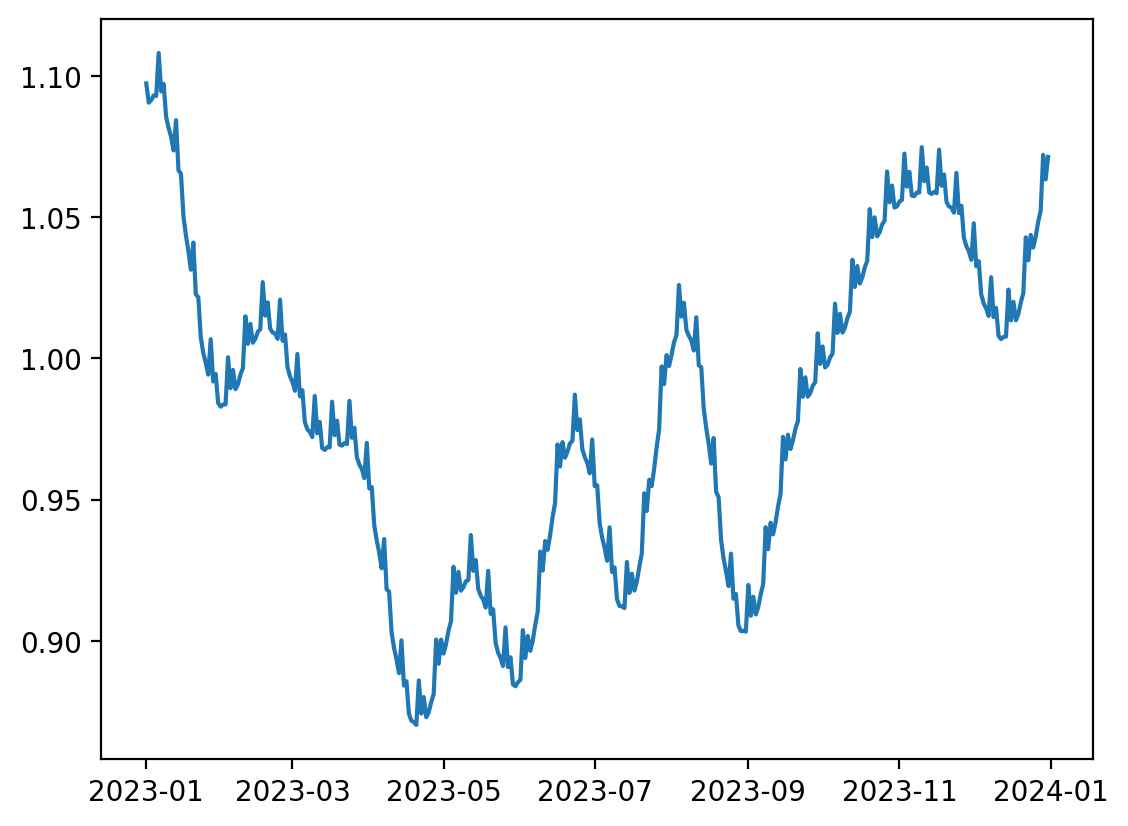

In [35]:
import matplotlib.pyplot as plt
from IPython.display import display
forecast_2023_onward = forecast[forecast["ds"].dt.year == 2023]

display(forecast_2023_onward)
plt.plot(forecast_2023_onward.ds, forecast_2023_onward.yhat)